In [3]:
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf
import plotly.express as px


In [4]:
data = pd.read_csv("data.csv")

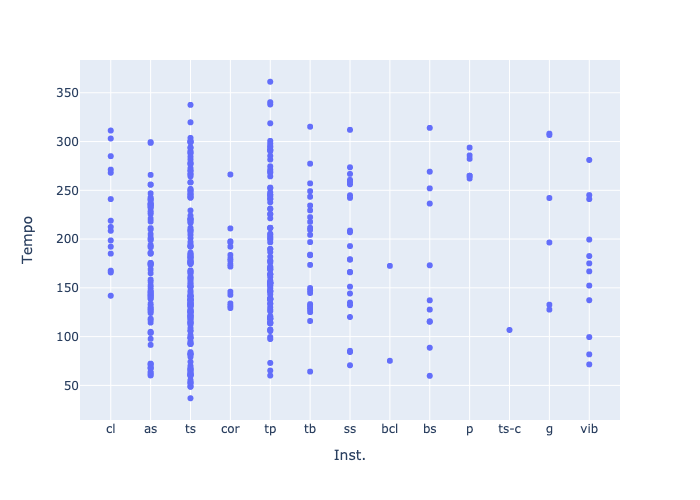

In [5]:
fig1 = px.scatter(data,x="Inst.",y="Tempo")
fig1.show("png")

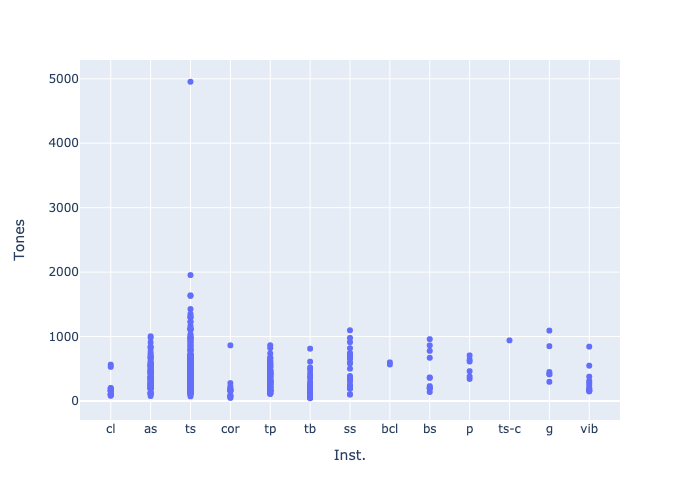

In [6]:
fig2 = px.scatter(data,x="Inst.",y="Tones")
fig2.show("png")

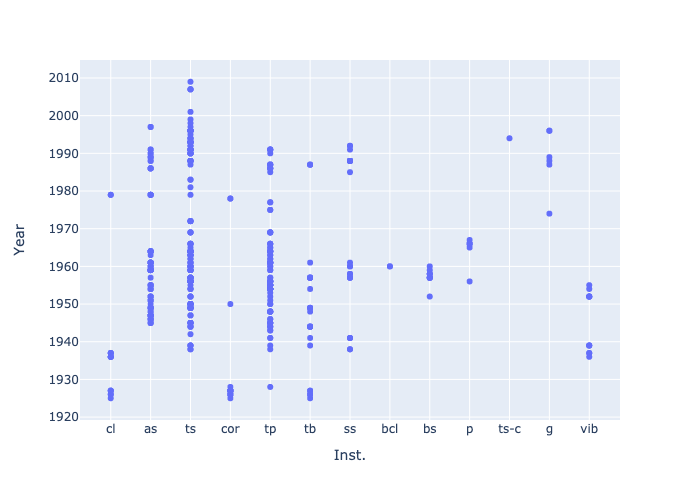

In [7]:
fig3 = px.scatter(data,x="Inst.",y="Year")
fig3.show("png")

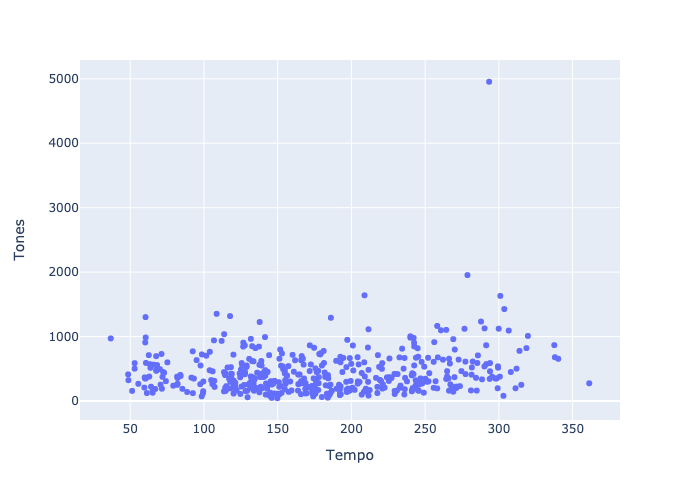

In [8]:
px.scatter(data,x="Tempo",y="Tones").show("png")

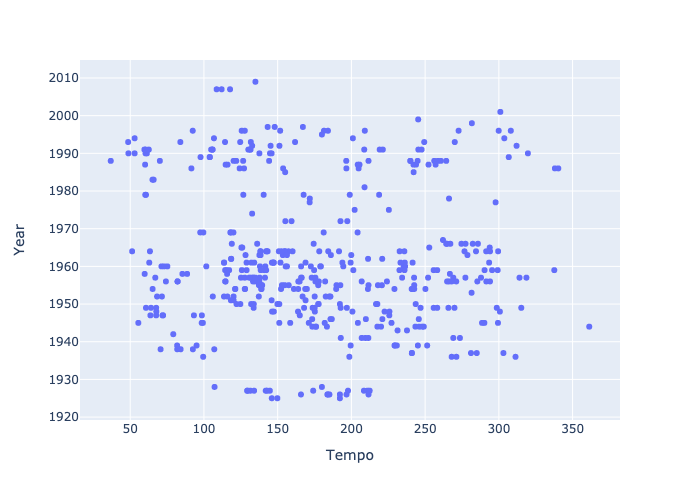

In [9]:
px.scatter(data,x="Tempo",y="Year").show("png")


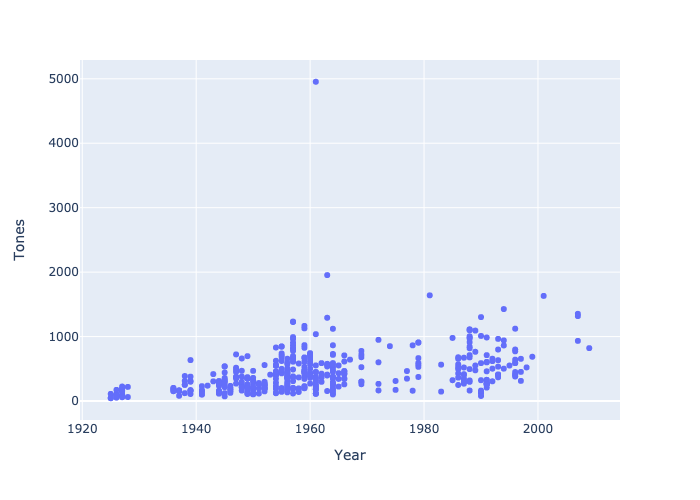

In [10]:
px.scatter(data,x="Year",y="Tones").show("png")

Maybe slight correlation between Tones and Year? This makes sense since audio clarity in speakers and fidelity in recording equipment has improved over the years. Maybe jazz musicians have also gotten more expressive and experimental with certian songwriting, recording and arrangement techniques.

In [11]:
data["Year"].corr(data["Tones"])

0.3866235236784666

Not a very strong correlation, however.

In [12]:
year = pd.to_numeric(data["Year"])
tones = pd.to_numeric(data["Tones"])
tempo = pd.to_numeric(data["Tempo"])


In [13]:
data["Inst"].value_counts()


Inst
ts      157
tp      102
as       80
tb       26
ss       23
cl       15
cor      15
vib      12
bs       11
p         6
g         6
bcl       2
ts-c      1
Name: count, dtype: int64

In [14]:
#map = {'':1,'':2,'':3,'':4,'':5,'':6,'':7,'':8,'':9,'':10,'':11,'':12,'':13,}
inst = pd.factorize(data["Inst"])
inst

(array([ 0,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  0,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  4,  4,  4,  4,  4,  4,  4,  4,  4,  2,  2,  2,  2,  2,  2,  5,
         5,  6,  6,  6,  6,  6,  2,  6,  6,  2,  6,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  5,  5,  5,  5,  5,  5,  4,  4,  4,  4,
         4,  4,  2,  2,  2,  2,  2,  2,  2,  2,  4,  4,  4,  4,  4,  4,  1,
         1,  1,  1,  7,  7,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         2,  8,  8,  8,  8,  8,  8,  2,  2,  2,  2,  4,  4,  9,  9,  9,  9,
         9,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2, 10,  2,  2,  6, 11,  2,  2,  2,  2,  2,  2,  2,
         2, 

In [15]:
df = pd.DataFrame({'inst':inst[0],'year':year,'tempo':tempo,'tones':tones})


In [16]:
df.drop(df.loc[].index,inplace=True)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3171790284.py, line 1)

In [ ]:
df.drop(df.loc[df['inst']==10].index,inplace=True)

In [ ]:
df.drop(df.loc[df['inst']==11].index,inplace=True)

In [ ]:
df.drop(df.loc[df['inst']==9].index,inplace=True)

In [ ]:
fit1 = smf.mnlogit('inst~tempo',data=df).fit()
print(fit1.summary())

Optimization terminated successfully.
         Current function value: 1.737043
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                   inst   No. Observations:                  441
Model:                        MNLogit   Df Residuals:                      425
Method:                           MLE   Df Model:                            8
Date:                Mon, 15 May 2023   Pseudo R-squ.:                 0.01139
Time:                        18:19:10   Log-Likelihood:                -766.04
converged:                       True   LL-Null:                       -774.86
Covariance Type:            nonrobust   LLR p-value:                   0.02394
    inst=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1438      0.975      4.252      0.000       2.234       6.054
tempo         -0.0126      0.

In [ ]:
fit2 = smf.mnlogit('inst~year+tempo+tones',data=df).fit()
print(fit2.summary())

Optimization terminated successfully.
         Current function value: nan
         Iterations 9


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning:

overflow encountered in exp

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning:

invalid value encountered in divide



                          MNLogit Regression Results                          
Dep. Variable:                   inst   No. Observations:                  441
Model:                        MNLogit   Df Residuals:                      409
Method:                           MLE   Df Model:                           24
Date:                Mon, 15 May 2023   Pseudo R-squ.:                     nan
Time:                        18:19:10   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -774.86
Covariance Type:            nonrobust   LLR p-value:                       nan
    inst=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept         nan        nan        nan        nan         nan         nan
year              nan        nan        nan        nan         nan         nan
tempo             nan        nan        nan        n

In [ ]:
fitnull = smf.mnlogit('inst~1',data=df).fit()
print(fitnull.summary())

Optimization terminated successfully.
         Current function value: 1.757063
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                   inst   No. Observations:                  441
Model:                        MNLogit   Df Residuals:                      433
Method:                           MLE   Df Model:                            0
Date:                Mon, 15 May 2023   Pseudo R-squ.:               3.368e-10
Time:                        18:19:11   Log-Likelihood:                -774.86
converged:                       True   LL-Null:                       -774.86
Covariance Type:            nonrobust   LLR p-value:                       nan
    inst=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6740      0.281      5.949      0.000       1.123       2.225
-----------------------------

In [21]:
df = pd.DataFrame({'inst':inst[0],'year':year,'tempo':tempo,'tones':tones})
df['inst'].value_counts()

inst
2     157
4     102
1      80
5      26
6      23
0      15
3      15
12     12
8      11
9       6
11      6
7       2
10      1
Name: count, dtype: int64

In [36]:
df2=df.loc[(df['inst'] == 2) | (df['inst'] == 4) | (df['inst'] == 1)]

In [37]:
df2.to_csv("df2.csv")

In [41]:
fit=smf.mnlogit('inst~tones+tempo+year',data=df2).fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.975171
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                   inst   No. Observations:                  339
Model:                        MNLogit   Df Residuals:                      331
Method:                           MLE   Df Model:                            6
Date:                Mon, 15 May 2023   Pseudo R-squ.:                 0.07883
Time:                        18:43:41   Log-Likelihood:                -330.58
converged:                       True   LL-Null:                       -358.87
Covariance Type:            nonrobust   LLR p-value:                 2.220e-10
    inst=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.7768     17.741     -1.453      0.146     -60.549       8.995
tones          0.0014      0.